<a href="https://colab.research.google.com/github/Taejin1221/Lab_Experiment/blob/main/GPS_Augmentation/GAN_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modules

In [21]:
import glob, time, cv2, os
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

In [22]:
CURR_DIR = '/content'

DRIVE_DIR = 'drive/MyDrive'
RESULT_DIR = 'Results'

In [23]:
IMG_SIZE = 28

# Build Models

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [25]:
(x_data, y_data), (x_test, y_test) = keras.datasets.mnist.load_data()
x_data = x_data.reshape( x_data.shape[0], IMG_SIZE, IMG_SIZE, 1 ).astype('float32')
x_test = x_test.reshape( x_test.shape[0], IMG_SIZE, IMG_SIZE, 1 ).astype( 'float32' )

x_data = ( x_data - 127.5 ) / 127.5
x_test = ( x_test - 127.5 ) / 127.5

In [26]:
BUFFER_SIZE = 60_000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Build Generator Model

In [27]:
generator = keras.Sequential( name = 'generator' )

generator.add( layers.Input( [ IMG_SIZE, IMG_SIZE, 1 ] ) )

# output shape ( 28, 28, 16 )
generator.add( layers.Conv2DTranspose( 16, ( 5, 5 ), padding = 'same', use_bias = False ) )
generator.add( layers.BatchNormalization( ) )
generator.add( layers.LeakyReLU( ) )

# output shape ( 28, 28, 32 )
generator.add( layers.Conv2DTranspose( 32, ( 5, 5 ), padding = 'same', use_bias = False ) )
generator.add( layers.BatchNormalization( ) )
generator.add( layers.LeakyReLU( ) )

 # output shape ( 128, 128, 64 )
generator.add( layers.Conv2DTranspose( 64, ( 5, 5 ), padding = 'same', use_bias = False ) )
generator.add( layers.BatchNormalization( ) )
generator.add( layers.LeakyReLU( ) )

# output shape ( 32, 32, 1 )
generator.add( layers.Conv2DTranspose( 1, ( 5, 5 ), padding = 'same', use_bias = False, activation = 'tanh' ) )

In [28]:
# generator.compile( )
# generator.summary()

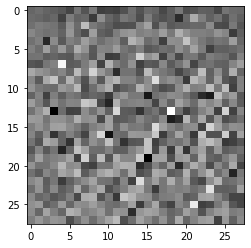

In [29]:
noise = tf.random.normal( [ 1, IMG_SIZE, IMG_SIZE, 1 ] )
generated_image = generator( noise, training = False )

plt.imshow( generated_image[ 0, :, :, 0 ], cmap = 'gray' )

In [30]:
generated_image.shape

TensorShape([1, 28, 28, 1])

## Build Discriminator Model

In [31]:
discriminator = keras.Sequential( name = 'discriminator' )

discriminator.add( layers.Conv2D( 16, ( 5, 5 ), strides = ( 2, 2 ), padding = 'same',
                                 input_shape = [ IMG_SIZE, IMG_SIZE, 1 ] ) )
discriminator.add( layers.LeakyReLU( ) )
discriminator.add( layers.Dropout( 0.3 ) )

discriminator.add( layers.Conv2D( 32, ( 5, 5 ), strides = ( 2, 2 ), padding = 'same' ) )
discriminator.add( layers.LeakyReLU( ) )
discriminator.add( layers.Dropout( 0.3 ) )

discriminator.add( layers.Flatten( ) )
discriminator.add( layers.Dense( 1 ) )

In [32]:
decision = discriminator( generated_image )
print( decision )

tf.Tensor([[0.00670436]], shape=(1, 1), dtype=float32)


# Train the models

## Define loss and optimizers

In [33]:
cross_entropy = keras.losses.BinaryCrossentropy( from_logits = True )

In [34]:
def discriminator_loss( real_output, fake_output ):
    real_loss = cross_entropy( tf.ones_like( real_output ), real_output )
    fake_loss = cross_entropy( tf.zeros_like( fake_output ), fake_output )

    total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss( fake_output ):
    return cross_entropy( tf.ones_like( fake_output ), fake_output )

In [35]:
generator_optimizer = tf.keras.optimizers.Adam( 1e-4 )
discriminator_optimizer = tf.keras.optimizers.Adam( 1e-4 )

## Define Hyperparameter

In [36]:
EPOCHS = 1000
example_row = 4
example_col = 4
num_examples_to_generate = 16

## Define Train Function

In [37]:
seed = tf.random.normal( [ num_examples_to_generate, IMG_SIZE, IMG_SIZE, 1 ] )

In [38]:
def generate_and_save_images( epochs ):
    predictions = generator( seed, training = False )

    n = num_examples_to_generate
    fig, ax = plt.subplots( example_row, example_col, True, True, figsize = ( 16, 12 ) )
    for i in range( n ):
        ax[i // example_row][i % example_col].imshow( tf.reshape( predictions[i], ( IMG_SIZE, IMG_SIZE ) ) )

    plt.savefig( 'Result_at_epoch_{:04d}.png'.format( epochs ) )
    plt.show()

In [39]:
@tf.function
def train_step( images ):
    noise = tf.random.normal( [ BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1 ] )

    with tf.GradientTape( ) as gen_tape, tf.GradientTape( ) as disc_tape:
      generated_images = generator( noise, training = True )

      real_output = discriminator( images, training = True )
      fake_output = discriminator( generated_images, training = True )

      gen_loss = generator_loss( fake_output )
      disc_loss = discriminator_loss( real_output, fake_output )

    gradients_of_generator = gen_tape.gradient( gen_loss, generator.trainable_variables )
    gradients_of_discriminator = disc_tape.gradient( disc_loss, discriminator.trainable_variables )

    generator_optimizer.apply_gradients( zip( gradients_of_generator, generator.trainable_variables ) )
    discriminator_optimizer.apply_gradients( zip( gradients_of_discriminator, discriminator.trainable_variables ) )

def train( dataset, epochs ):
    plt.gray()
    os.chdir( os.path.join( CURR_DIR, DRIVE_DIR ) )
    if ( RESULT_DIR not in os.listdir() ):
        os.mkdir( RESULT_DIR )
    os.chdir( RESULT_DIR )

    for epoch in range( epochs ):
        start = time.time( )

        for image_batch in dataset:
            train_step( image_batch )

        if ( epoch % 50 == 0 ):
            display.clear_output(wait=True)
            generate_and_save_images( epoch )

        print( 'Time for epoch {:02d} is {:.4f} sec'.format( epoch + 1, time.time( ) - start ) )

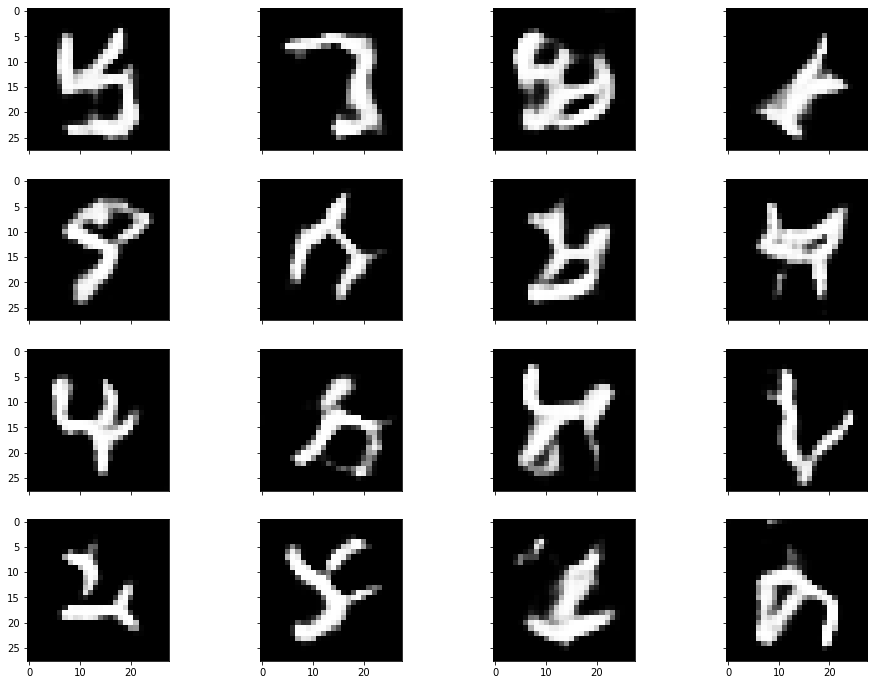

Time for epoch 951 is 8.1672 sec
Time for epoch 952 is 5.1235 sec
Time for epoch 953 is 5.1106 sec
Time for epoch 954 is 5.1095 sec
Time for epoch 955 is 5.1226 sec
Time for epoch 956 is 5.1380 sec
Time for epoch 957 is 5.1391 sec
Time for epoch 958 is 5.1333 sec
Time for epoch 959 is 5.1345 sec
Time for epoch 960 is 5.1188 sec
Time for epoch 961 is 5.1285 sec
Time for epoch 962 is 5.1188 sec
Time for epoch 963 is 5.1124 sec
Time for epoch 964 is 5.1064 sec
Time for epoch 965 is 5.1256 sec
Time for epoch 966 is 5.1072 sec
Time for epoch 967 is 5.1376 sec
Time for epoch 968 is 5.1102 sec
Time for epoch 969 is 5.1216 sec
Time for epoch 970 is 5.1093 sec
Time for epoch 971 is 5.1038 sec
Time for epoch 972 is 5.1170 sec
Time for epoch 973 is 5.1303 sec
Time for epoch 974 is 5.1240 sec
Time for epoch 975 is 5.1183 sec
Time for epoch 976 is 5.1490 sec
Time for epoch 977 is 5.1254 sec
Time for epoch 978 is 5.1292 sec
Time for epoch 979 is 5.1158 sec
Time for epoch 980 is 5.1214 sec
Time for e

In [40]:
train( train_dataset, EPOCHS )

# Test Model

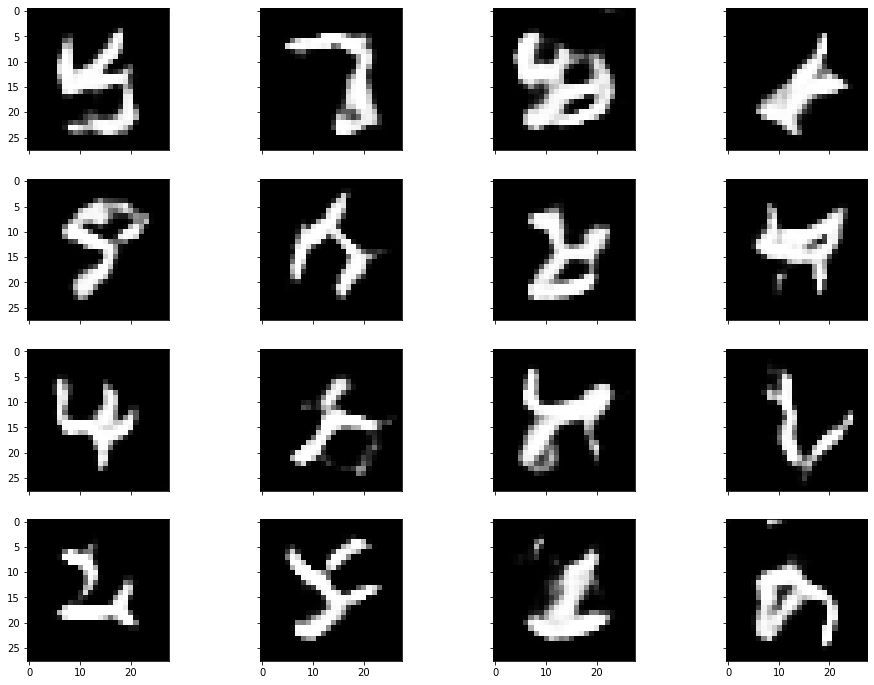

In [41]:
predicted_images = generator( seed )

n = num_examples_to_generate
fig, ax = plt.subplots( example_row, example_col, True, True, figsize = ( 16, 12 ) )
for i in range( n ):
    ax[i // example_row][i % example_col].imshow( tf.reshape( predicted_images[i], ( IMG_SIZE, IMG_SIZE ) ) )
plt.savefig( 'Result_Final.png' )